In [105]:
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats

In [106]:
df = pd.read_pickle("/glade/work/hpzhang/LCC_pred/data/data_monthly.pkl").dropna()
df = df[df.index.year.isin(np.arange(2015,2019))]

pred_XGB    = np.load('/glade/work/hpzhang/LCC_pred/data/XGB/y_pred_XGB.npy')

pred_XGB_DJF  = np.load('/glade/work/hpzhang/LCC_pred/data/XGB_diff_season/y_pred_XGB_DJF.npy')
pred_XGB_MAM  = np.load('/glade/work/hpzhang/LCC_pred/data/XGB_diff_season/y_pred_XGB_MAM.npy')
pred_XGB_JJA  = np.load('/glade/work/hpzhang/LCC_pred/data/XGB_diff_season/y_pred_XGB_JJA.npy')
pred_XGB_SON  = np.load('/glade/work/hpzhang/LCC_pred/data/XGB_diff_season/y_pred_XGB_SON.npy')                        

In [107]:
df_new = pd.DataFrame({'LCF':df['LCF'],
                       'XGB':pred_XGB,
                      }, index=df.index)

In [108]:
DJF = [12, 1, 2]
MAM = [3, 4, 5]
JJA = [6, 7, 8]
SON = [9, 10, 11]

df_new['XGB_seasons'] = np.NaN
df_new.loc[df_new.index.month.isin(DJF), 'XGB_seasons'] = pred_XGB_DJF
df_new.loc[df_new.index.month.isin(MAM), 'XGB_seasons'] = pred_XGB_MAM
df_new.loc[df_new.index.month.isin(JJA), 'XGB_seasons'] = pred_XGB_JJA
df_new.loc[df_new.index.month.isin(SON), 'XGB_seasons'] = pred_XGB_SON

df_new['season'] = ''
df_new.loc[df_new.index.month.isin(DJF), 'season']='DJF'
df_new.loc[df_new.index.month.isin(MAM), 'season']='MAM'
df_new.loc[df_new.index.month.isin(JJA), 'season']='JJA'
df_new.loc[df_new.index.month.isin(SON), 'season']='SON'

df_new = pd.melt(df_new, id_vars=['season','LCF'], var_name='model', value_name='pred')

In [109]:
def get_res(df_in):
    mse = mean_squared_error(df_in['LCF'], df_in['pred'])
    mae = mean_absolute_error(df_in['LCF'], df_in['pred'])
    r,p = scipy.stats.pearsonr(df_in['LCF'], df_in['pred'])
    ttest = stats.ttest_ind(df_in['LCF'], df_in['pred'])[1]
    
    res = pd.Series([mse,mae,r,p,ttest], index=['MSE','MAE','r','p','ttest'])

    return(res)    
    
 
res       = df_new.groupby(['model','season']).apply(get_res).reset_index(level=[0,1])
res.ttest = round(res.ttest, 2)
plt_dat = pd.melt(res, id_vars=['model','season','p','ttest'], var_name='type')

In [110]:
res

,model,season,MSE,MAE,r,p,ttest
0,XGB,DJF,0.003856,0.047774,0.916611,0.0,0.00
1,XGB,JJA,0.003587,0.045681,0.941402,0.0,0.00
2,XGB,MAM,0.003493,0.045217,0.923638,0.0,0.00
3,XGB,SON,0.003617,0.046050,0.937022,0.0,0.13
4,XGB_seasons,DJF,0.004034,0.048994,0.912342,0.0,0.00
5,XGB_seasons,JJA,0.003855,0.047060,0.936745,0.0,0.00
6,XGB_seasons,MAM,0.003697,0.046630,0.918821,0.0,0.00
7,XGB_seasons,SON,0.003763,0.047030,0.934710,0.0,0.00


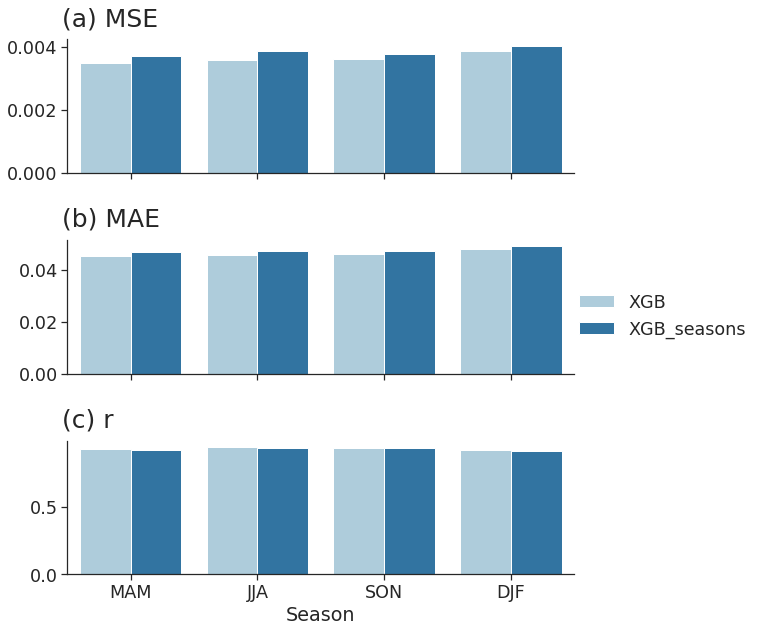

In [112]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale = 1.6)

g = sns.FacetGrid(plt_dat, row="type", sharey=False, height=3, aspect=3)
g.map(sns.barplot, "season", "value", 'model',
      order=['MAM', 'JJA', 'SON', 'DJF'],
      hue_order=['XGB', 'XGB_seasons'],
      palette="Paired")
g.add_legend()

axes = g.axes.flatten()
axes[2].set_xlabel('Season')

ti = ['(a) MSE','(b) MAE','(c) r']

for i, ax in enumerate(axes):
    ax.set_title('')
    ax.set_ylabel('')
    ax.annotate(ti[i], xy=(-0.01, 1.1), xycoords='axes fraction', fontsize=25)
#    ax.set_ylim([0,1]) if i==2 else None
    
plt.subplots_adjust(hspace=0.5) 
plt.show()
